# Exercise 3

## 1 Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

In [3]:
plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])

Epoch: 0
Mean Train Loss: 4.01e-01
Mean Test Loss:  1.94e-01
Epoch: 10
Mean Train Loss: 1.59e-01
Mean Test Loss:  2.10e-01
Epoch: 20
Mean Train Loss: 1.09e-01
Mean Test Loss:  4.49e-01
Epoch: 30
Mean Train Loss: 6.97e-02
Mean Test Loss:  4.87e-01
Epoch: 40
Mean Train Loss: 5.78e-02
Mean Test Loss:  6.21e-01
Epoch: 50
Mean Train Loss: 3.29e-02
Mean Test Loss:  7.95e-01
Epoch: 60
Mean Train Loss: 2.18e-02
Mean Test Loss:  8.17e-01
Epoch: 70
Mean Train Loss: 3.09e-02
Mean Test Loss:  7.81e-01
Epoch: 80
Mean Train Loss: 1.31e-02
Mean Test Loss:  9.79e-01
Epoch: 90
Mean Train Loss: 2.10e-02
Mean Test Loss:  9.74e-01
Epoch: 100
Mean Train Loss: 1.13e-02
Mean Test Loss:  8.76e-01


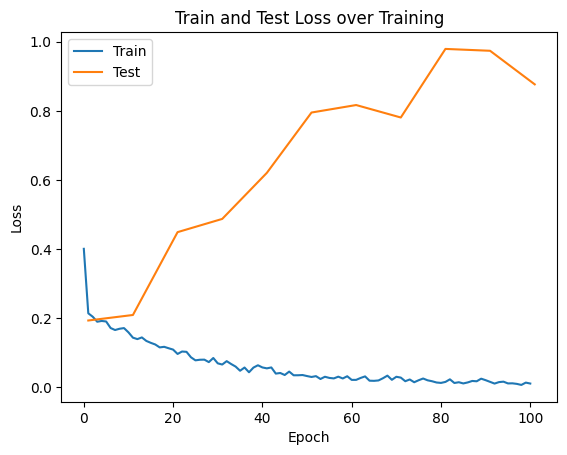

In [5]:
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## 2 Dropout

In [6]:
def dropout(X, p_drop = 0.5):
    if 0 < p_drop < 1:
        p = torch.ones(X.size()) * p_drop
        phi = torch.bernoulli(p).bool()
        
        X[phi] = 0
        X[~phi] *= (1-p_drop)**(-1)
        
        return X
    
    else:
        return X

In [7]:
def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    test = X
    x = dropout(X, p_drop_input)
    h = rectify(x @ w_h)
    
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    
    return pre_softmax

Epoch: 0
Mean Train Loss: 6.84e-01
Mean Test Loss:  2.59e-01
Epoch: 10
Mean Train Loss: 6.35e-01
Mean Test Loss:  2.06e-01
Epoch: 20
Mean Train Loss: 7.40e-01
Mean Test Loss:  2.87e-01
Epoch: 30
Mean Train Loss: 8.44e-01
Mean Test Loss:  3.10e-01
Epoch: 40
Mean Train Loss: 8.95e-01
Mean Test Loss:  4.24e-01
Epoch: 50
Mean Train Loss: 9.20e-01
Mean Test Loss:  4.20e-01
Epoch: 60
Mean Train Loss: 1.01e+00
Mean Test Loss:  3.69e-01
Epoch: 70
Mean Train Loss: 1.04e+00
Mean Test Loss:  4.88e-01
Epoch: 80
Mean Train Loss: 1.06e+00
Mean Test Loss:  5.86e-01
Epoch: 90
Mean Train Loss: 1.03e+00
Mean Test Loss:  5.57e-01
Epoch: 100
Mean Train Loss: 1.12e+00
Mean Test Loss:  4.59e-01


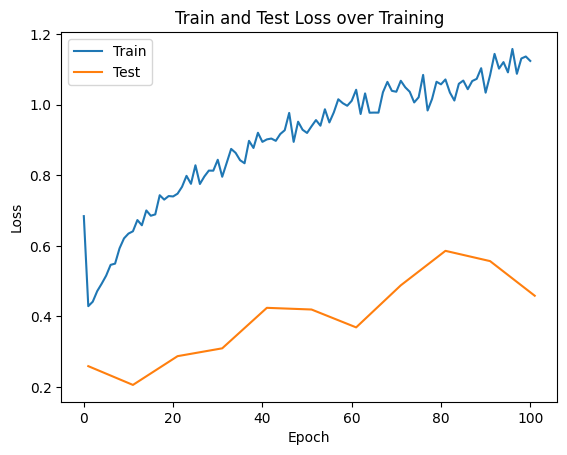

In [8]:
n_epochs = 100

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])

train_loss = []
test_loss = []

p_drop_input = 0.1
p_drop_hidden = 0.5

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden) # add new model here

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The dropout method reduces the input to less features, either in the input layer or in the hidden layers by just nulling some random elements. <br>
This prevents overfitting because the training data in the beginning would influence the weigths and biases significantly more than later data. Also each neuron is forced to consider all neurons from the previous layer, since it can't relay on specific neurons anymore.<br>
The test data shouldn't go through the dropout layer, else we wouldn't use all the neurons we trained with. <br>
Compared to the loss of the test data to the one from task 1, we can see that the loss with the dropout has improved over the epochs. This indicates, that we prevented the overfitting that occured in task 1.

## 3 Parametric ReLU

In [9]:
def PRelu(X,a):
    X[X<=0] *= a[X<=0]
    return X

In [10]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
a_h = init_weights((100, 625))
a_h2 = init_weights((100, 625))

optimizer = RMSprop(params=[w_h, w_h2, w_o, a_h, a_h2])

# define the neural network with the new ReLu
def model(x, w_h, w_h2, w_o, a_h, a_h2):
    h = PRelu(x @ w_h, a_h)
    h2 = PRelu(h @ w_h2, a_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

Epoch: 0
Mean Train Loss: 4.30e-01
Mean Test Loss:  2.60e-01
Epoch: 10
Mean Train Loss: 1.10e-01
Mean Test Loss:  2.44e-01
Epoch: 20
Mean Train Loss: 8.26e-02
Mean Test Loss:  2.72e-01
Epoch: 30
Mean Train Loss: 7.64e-02
Mean Test Loss:  2.45e-01
Epoch: 40
Mean Train Loss: 6.63e-02
Mean Test Loss:  3.18e-01
Epoch: 50
Mean Train Loss: 5.85e-02
Mean Test Loss:  3.84e-01
Epoch: 60
Mean Train Loss: 6.05e-02
Mean Test Loss:  3.74e-01
Epoch: 70
Mean Train Loss: 5.68e-02
Mean Test Loss:  3.54e-01
Epoch: 80
Mean Train Loss: 5.32e-02
Mean Test Loss:  4.54e-01
Epoch: 90
Mean Train Loss: 4.25e-02
Mean Test Loss:  4.84e-01
Epoch: 100
Mean Train Loss: 4.97e-02
Mean Test Loss:  4.69e-01


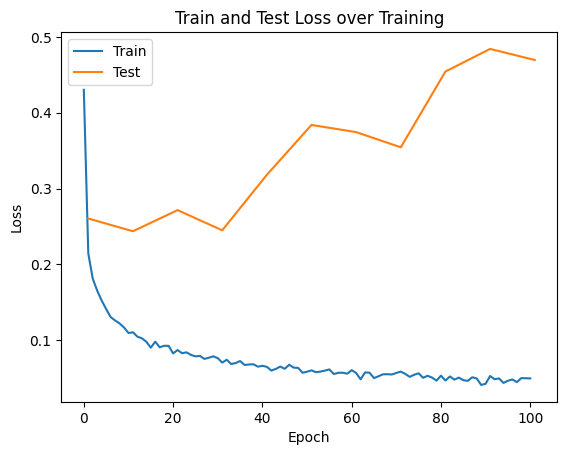

In [11]:
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o, a_h, a_h2) # add new ReLU here

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o, a_h, a_h2) # add new ReLU here

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

With the parametric ReLU the NN still overfits the training data, but the Loss is noticable lower compared to the normal ReLU activation (around half).

## 4 Convolutional Layers
### 4.1 Create a Convolutional network

In [12]:
# define the neural network with convolutional layers
def conv_model(x, kernal1, kernal2, kernal3, w_h2, w_o, p_drop_input, p_drop_hidden):

    # first layer with convolution, pooling and dropout
    convolutional_layer = rectify(conv2d(x , kernal1))
    subsampling_layer = max_pool2d(convolutional_layer , (2,2))
    hc = dropout(subsampling_layer , p_drop_input)
    
    # second layer with convolution, pooling and dropout
    convolutional_layer = rectify(conv2d(hc , kernal2))
    subsampling_layer = max_pool2d(convolutional_layer , (2,2))
    hc2 = dropout(subsampling_layer , p_drop_hidden)
    
    # third layer with convolution, pooling and dropout
    convolutional_layer = rectify(conv2d(hc2 , kernal3))
    subsampling_layer = max_pool2d(convolutional_layer , (2,2))
    hc3 = dropout(subsampling_layer , p_drop_hidden)
    
    h2 = hc3.reshape(100, 128) @ w_h2
    pre_softmax = h2 @ w_o
    
    return pre_softmax

Epoch: 0
Mean Train Loss: 2.31e+00
Mean Test Loss:  4.14e-01
Epoch: 10
Mean Train Loss: 2.96e-01
Mean Test Loss:  9.83e-02
Epoch: 20
Mean Train Loss: 2.59e-01
Mean Test Loss:  7.36e-02
Epoch: 30
Mean Train Loss: 2.54e-01
Mean Test Loss:  7.66e-02
Epoch: 40
Mean Train Loss: 2.51e-01
Mean Test Loss:  7.13e-02
Epoch: 50
Mean Train Loss: 2.48e-01
Mean Test Loss:  6.51e-02
Epoch: 60
Mean Train Loss: 2.52e-01
Mean Test Loss:  6.93e-02
Epoch: 70
Mean Train Loss: 2.61e-01
Mean Test Loss:  7.72e-02
Epoch: 80
Mean Train Loss: 2.69e-01
Mean Test Loss:  7.32e-02
Epoch: 90
Mean Train Loss: 2.72e-01
Mean Test Loss:  8.49e-02
Epoch: 100
Mean Train Loss: 2.94e-01
Mean Test Loss:  7.98e-02


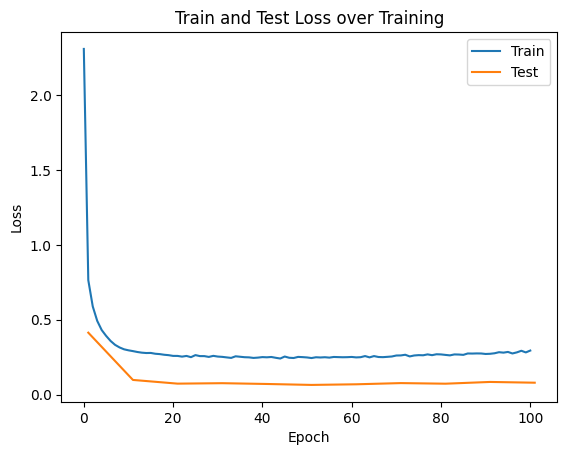

In [13]:
number_of_output_pixel = 128
n_epochs = 100

# initialize weights

# input shape is (B, 784)
kernal1 = init_weights((32, 1, 5, 5))
# hidden layer with 625 neurons
kernal2 = init_weights((64, 32, 5, 5))
# hidden layer with 625 neurons
kernal3 = init_weights((128, 64, 2, 2))
# hidden layer with 625 neurons
w_h2 = init_weights((number_of_output_pixel, 625))
# hidden layer with 625 neurons
w_o = init_weights((625,10))
# output shape is (B, 10)

optimizer = RMSprop(params=[kernal1, kernal2, kernal3, w_h2, w_o])

train_loss = []
test_loss = []

p_drop_input = 0.1
p_drop_hidden = 0.5

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # feed input through model
        noise_py_x = conv_model(x, kernal1, kernal2, kernal3, w_h2, w_o, p_drop_input, p_drop_hidden) # add new model here

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                noise_py_x = conv_model(x, kernal1, kernal2, kernal3, w_h2, w_o, 1, 1) # add new model here, with zero dropout = 1 to consider all data

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
        
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## 4.2 Application of Convolutional network
### Plotting of the layers

In [14]:
# define the neural network with convolutional layers
def plot_conv_model(x, kernal1, kernal2, kernal3, w_h2, w_o, p_drop_input, p_drop_hidden):
    
    plt.imshow(x[0][0], interpolation="bicubic")
    plt.title("Input")
    plt.show()
    
    # first layer with convolution, pooling and dropout
    convolutional_layer = rectify(conv2d(x , kernal1))
    subsampling_layer = max_pool2d(convolutional_layer , (2,2))
    hc = dropout(subsampling_layer , p_drop_input)
    
    fig, axs = plt.subplots(2,3)
    for i in range(0,3):
        fig.suptitle("First convolutional layer")
        axs[1,i].imshow(conv2d(x , kernal1)[0][i].detach().numpy(), interpolation="bicubic")
        axs[1,i].set(ylabel='convolutions')
        axs[0,i].imshow(kernal1.detach().numpy()[i][0], interpolation="bicubic")
        axs[0,i].set(ylabel='Kernals')
        
    for ax in axs.flat:
        ax.label_outer()
    plt.show()
    
    # second layer with convolution, pooling and dropout
    convolutional_layer = rectify(conv2d(hc , kernal2))
    subsampling_layer = max_pool2d(convolutional_layer , (2,2))
    hc2 = dropout(subsampling_layer , p_drop_hidden)
    
    fig, axs = plt.subplots(2,3)
    for i in range(0,3):
        fig.suptitle("Second convolutional layer")
        axs[1,i].imshow(conv2d(hc , kernal2)[0][i].detach().numpy(), interpolation="bicubic")
        axs[1,i].set(ylabel='convolutions')
        axs[0,i].imshow(kernal2.detach().numpy()[i][0], interpolation="bicubic")
        axs[0,i].set(ylabel='Kernals')
        
        for ax in axs.flat:
            ax.label_outer()
    plt.show()
    
    # third layer with convolution, pooling and dropout
    convolutional_layer = rectify(conv2d(hc2 , kernal3))
    subsampling_layer = max_pool2d(convolutional_layer , (2,2))
    hc3 = dropout(subsampling_layer , p_drop_hidden)
    
    fig, axs = plt.subplots(2,3)
    for i in range(0,3):
        fig.suptitle("Third convolutional layer")
        axs[1,i].imshow(conv2d(hc2 , kernal3)[0][i].detach().numpy(), interpolation="bicubic")
        axs[1,i].set(ylabel='convolutions')
        axs[0,i].imshow(kernal2.detach().numpy()[i][0], interpolation="bicubic")
        axs[0,i].set(ylabel='Kernals')
        
        for ax in axs.flat:
            ax.label_outer()
    plt.show()
    
    h2 = hc3.reshape(100, 128) @ w_h2
    pre_softmax = h2 @ w_o

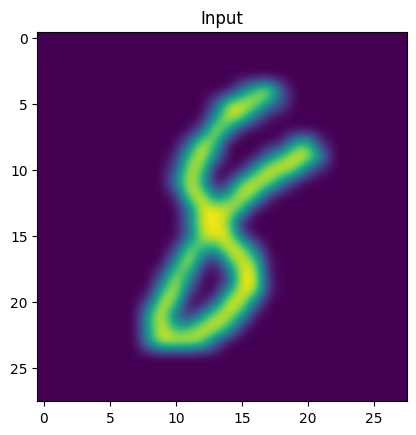

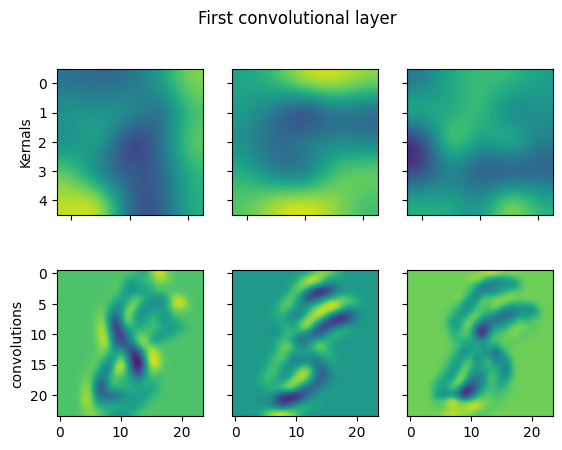

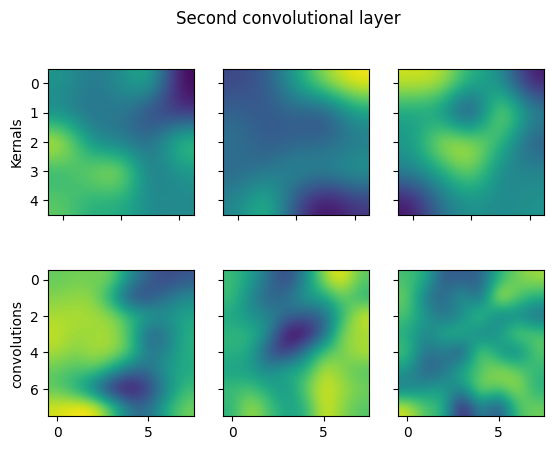

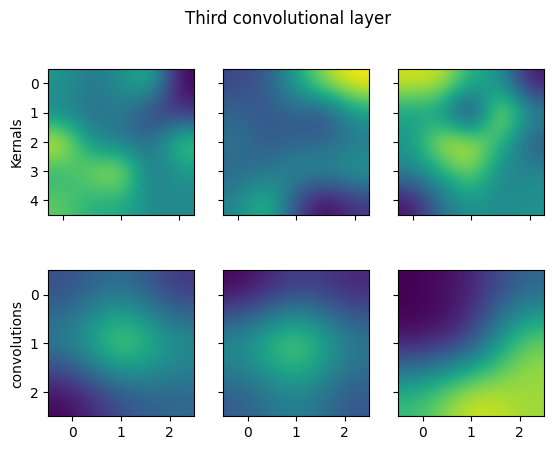

In [15]:
plot_conv_model(x, kernal1, kernal2, kernal3, w_h2, w_o, 1, 1)